#  Homework 2


**Due Date: ** Friday, Febrary 9th, 2017 at 10am

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [1]:
import numpy as np
import pandas as pd
# from scipy.stats import norm

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('talk')
%matplotlib inline

## Problem 1: Monte Carlo Integration

Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of $X$:

$$
h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}
$$

Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:
- inverse transform sampling
- rejection sampling with both uniform proposal distribution and normal proposal distribution (steroids) (with appropriately chosen parameters)

### Answer to Problem 1

From LOTUS and the law of large numbers, we know
$$\mathbb{E}[h(X)] = \int_D{h(x)f_X(x)dx}=\lim_{n\to\infty}{\frac{1}{N}\sum_{x_i\sim f}{h(x_i)}}$$

In [2]:
def p(x):
    if x < 1:
        return 0
    elif x <= 3:
        return (x - 1) / 12
    elif x <= 5:
        return (5 - x) / 12
    elif x <= 7:
        return (x - 5) / 6
    elif x <= 9:
        return (9 - x) / 6
    else:
        return 0
    
def CDF(x):
    if x < 1:
        return 0
    elif x <= 3:
        return (x - 1) ** 2 / 24
    elif x <= 5:
        return 1 / 3 - (x - 5) ** 2 / 24
    elif x <= 7:
        return 1 / 3 + (x - 5) ** 2 / 12
    elif x <= 9:
        return 1 - (x - 9) ** 2 / 12
    else:
        return 1
    
def invCDF(u):
    if u < 0 or u > 1:
        raise ValueError('Invalid input. Please make sure 0 <= u <= 1')
    elif u <= 1 / 6:
        return 1 + np.sqrt(24 * u)
    elif u <= 1 / 3:
        return 5 - np.sqrt(8 - 24 * u)
    elif u <= 2 / 3:
        return 5 + np.sqrt(12 * u - 4)
    else:
        return 9 - np.sqrt(12 - 12 * u)

def h(x):
    return np.exp(-(x - 5) ** 2 / 18) / (3 * np.sqrt(2) * np.pi)

#### Inverse transform sampling

In [3]:
def inv_sampling(N=10000):
    U = np.random.uniform(0, 1, N)
    X = np.array([invCDF(_u) for _u in U])
    return X

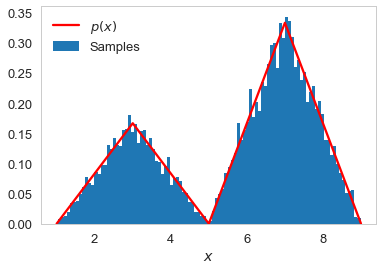

In [4]:
N = 10000
X = inv_sampling(N)

plt.hist(X, bins=100, normed=True, label=u'Samples');
xvals = np.arange(1, 9.1, 0.1)
plt.plot(xvals, [p(_x) for _x in xvals], 'r', label=u'$p(x)$');
plt.legend();
plt.xlabel('$x$');

As we can see, the inverse transform sampling works.

In [5]:
print('The estimated E[h(X)] via Monte Carlo simulation using inverse transform sampling is {}.'\
     .format(np.mean(h(X))))

The estimated E[h(X)] via Monte Carlo simulation using inverse transform sampling is 0.058975694691102684.


#### Rejection sampling with uniform proposal distribution

In [6]:
def uni_rej_sampling(N=10000, xmin=1, xmax=9, ymax=1/3, return_stat=False):
    accepted = 0
    count = 0
    X = np.zeros(N)
    while (accepted < N):
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(0, ymax)
        if y < p(x):
            X[accepted] = x
            accepted += 1
        count += 1
    if return_stat:
        return X, accepted, count
    else:
        return X

Count 26764; Accepted 10000


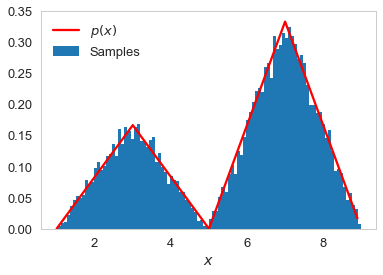

In [7]:
X, accepted, count = uni_rej_sampling(return_stat=True)   

print('Count {}; Accepted {}'.format(count, accepted))

plt.hist(X, bins=100, normed=True, label=u'Samples');
xvals = np.arange(1, 9, 0.1)
plt.plot(xvals, [p(_x) for _x in xvals], 'r', label=u'$p(x)$');
plt.legend();
plt.xlabel('$x$');

In [8]:
print('The estimated E[h(X)] via Monte Carlo simulation using rejection sampling with \
uniform proposal distribution is \n{}.'\
     .format(np.mean(h(X))))

The estimated E[h(X)] via Monte Carlo simulation using rejection sampling with uniform proposal distribution is 
0.05879118429417151.


#### Rejection sampling with normal proposal distribution

First we need to find a proper $M$ and $g(x)$ so that $M g(x) > f(x)$. From some trials, we find it is a good choice to set $M=3, \mu=6.5, \sigma=3$ as shown below.

In [9]:
def normpdf(x, loc, scale):
    u = (x - loc) / scale
    return (1 / np.sqrt(2 * np.pi) / scale) * np.exp(-u * u / 2)
    

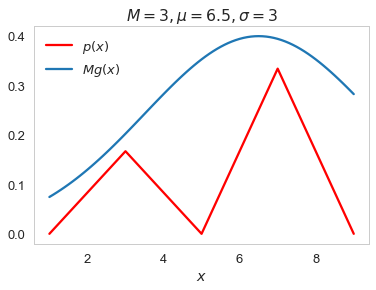

In [10]:
M = 3
mu = 6.5
sigma = 3
xvals = np.arange(1, 9.1, 0.1)
plt.plot(xvals, [p(_x) for _x in xvals], 'r', label=u'$p(x)$');
plt.plot(xvals, M * normpdf(xvals, loc=mu, scale=sigma), label=u'$M g(x)$');
plt.legend();
plt.xlabel('$x$');
plt.title('$M={}, \mu={}, \sigma={}$'.format(M, mu, sigma));

In [11]:
def norm_rej_sampling(N=10000, xmin=1, xmax=9, M=3, mu=6.5, sigma=3, return_stat=False):
    accepted = 0
    count = 0
    X = np.zeros(N)
    while (accepted < N):
        x = np.random.normal(loc=mu, scale=sigma)
        if xmin <= x and x <= xmax:
            y = np.random.uniform(0, 1)
            if y < p(x) / M / normpdf(x, loc=mu, scale=sigma):
                X[accepted] = x
                accepted += 1
        count += 1
    if return_stat:
        return X, accepted, count
    else:
        return X

Count 29915; Accepted 10000


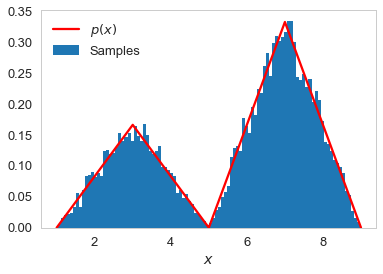

In [12]:
X, accepted, count = norm_rej_sampling(return_stat=True)

print('Count {}; Accepted {}'.format(count, accepted))

plt.hist(X, bins=100, normed=True, label=u'Samples');
xvals = np.arange(1, 9.1, 0.1)
plt.plot(xvals, [p(_x) for _x in xvals], 'r', label=u'$p(x)$');
plt.legend();
plt.xlabel('$x$');

In [13]:
print('The estimated E[h(X)] via Monte Carlo simulation using rejection sampling with \
normal proposal distribution is \n{}.'\
     .format(np.mean(h(X))))

The estimated E[h(X)] via Monte Carlo simulation using rejection sampling with normal proposal distribution is 
0.058855470407416996.


## Problem 2: Variance Reduction

### Part A

Compute the variance of each estimate of $\mathbb{E}[h(X)]$ obtained in Problem 1. What do you see?

### Part B (Stratified Sampling)

Often, a complex integral can be computed with more ease if one can break up the domain of the integral into pieces and if on each piece of the domain the integral is simplified. 

- Find a natural way to divide the domain of $X$ and express $\mathbb{E}[h(X)]$ as an ***correctly*** weighted sum of integrals over the pieces of the domain of $X$. (This constitutes the essentials of Stratified Sampling)

- Estimate each integral in the summand using rejection sampling using a normal proposal distribution (with sensibly chosen parameters). From these, estimate $\mathbb{E}[h(X)]$.

- Compute the variance of your estimate of $\mathbb{E}[h(X)]$. Compare with the variance of your previous estimate of $\mathbb{E}[h(X)]$ (in Part A, using rejection sampling, a normal proposal distribution over the entire domain of $X$).

Read more about Stratified Sampling:

1. [Monte Carlo Methods](http://www.public.iastate.edu/~mervyn/stat580/Notes/s09mc.pdf)

2. [Variance Reduction Techniques Chapter](http://sas.uwaterloo.ca/~dlmcleis/s906/chapt4.pdf)

### Answer to Problem 2 Part A

We can estimate the variance of each estimate by repeating each simulation 500 times, respectively.

In [14]:
%%time
N_rep = 500
E_inv = np.array([np.mean(h(inv_sampling())) for _ in range(N_rep)])

Wall time: 19.8 s


In [15]:
%%time
E_uni = np.array([np.mean(h(uni_rej_sampling())) for _ in range(N_rep)])

Wall time: 47.7 s


In [16]:
%%time
E_norm = np.array([np.mean(h(norm_rej_sampling())) for _ in range(N_rep)])

Wall time: 2min 12s


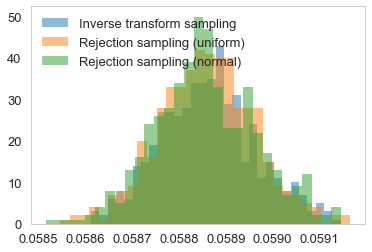

In [17]:
plt.hist(E_inv, 30, alpha=0.5, label='Inverse transform sampling');
plt.hist(E_uni, 30, alpha=0.5, label='Rejection sampling (uniform)');
plt.hist(E_norm, 30, alpha=0.5, label='Rejection sampling (normal)');
plt.legend(loc=2);

In [18]:
print('The estimated variance of each estimate of E[h(X)] (total sample size in each simulation: 10000):')
print('Inverse transform sampling {}'.format(np.var(E_inv)))
print('Rejection sampling with uniform proposal distribution {}'.format(np.var(E_uni)))
print('Rejection sampling with normal proposal distribution {}'.format(np.var(E_norm)))

The estimated variance of each estimate of E[h(X)] (total sample size in each simulation: 10000):
Inverse transform sampling 1.0315666174808508e-08
Rejection sampling with uniform proposal distribution 1.0346500921144041e-08
Rejection sampling with normal proposal distribution 1.1487608922210426e-08


As we can see, the variance of estimate obtained by 3 sampling methods is very close to each other.

### Answer to Problem 2 Part B

We break $[1, 9]$ into 8 equispaced strata and represent each region by $D_j$. We denote $\mathbb{E}[h(X)]$ as $\mu$, then we have
$$\mu=\mathbb{E}[h(X)] = \int_D h(x) f(x) dx = \sum_j \int_{D_j} h(x) f(x) dx$$
We define the probability of being in region $D_j$ as $p_j$, then 
$$p_j = \int_{D_j} f(x) dx = F(b)-F(a),$$
where $F(x)$ is the CDF of $f_X$, and $a, b$ are 2 end points of region $D_j$.

Then,
$$\mu = \sum_j p_j \int_{D_j} h(x) \frac{f(x)}{p_j} dx = \sum_j p_j \mu_j,$$
where
$$\mu_j = \mathbb{E}_{f_j}[h] = \int_{D_j} h(x) f_j(x) dx.$$

We can estimate each $\mu_j$ by
$$\hat{\mu_j} = \frac{1}{n_j} \sum_{x_i \sim f_j} h(x_i).$$

The estimation of $\mathbb{E}[h(X)]$ is
$$\hat{\mu} = \sum_j p_j \hat{\mu_j}.$$

Here, we use 2 normal proposal distributions for rejection sampling of different regions of $X$. We find a set of proper parameters through some trials. The result is shown below.

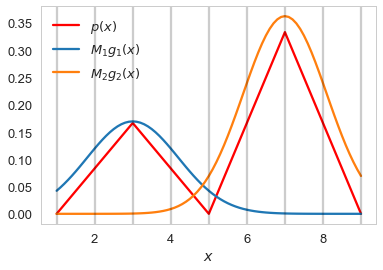

In [19]:
M1 = 0.51
mu1 = 3
sigma1 = 1.2

M2 = 1
mu2 = 7
sigma2 = 1.1

xvals = np.arange(1, 9.1, 0.1)
plt.plot(xvals, [p(_x) for _x in xvals], 'r', label=u'$p(x)$');
plt.plot(xvals, M1 * normpdf(xvals, loc=mu1, scale=sigma1), label=u'$M_1 g_1(x)$');
plt.plot(xvals, M2 * normpdf(xvals, loc=mu2, scale=sigma2), label=u'$M_2 g_2(x)$');
plt.legend();
plt.xlabel('$x$');

assert(M1 * normpdf(mu1, mu1, sigma1) > p(mu1))

xmin = 1
xmax = 9
Ns = 8
step = (xmax - xmin) / Ns
for j in range(Ns + 1):
    plt.axvline(xmin + j * step, 0, 1, color='k', alpha=0.2)

We write a class `Stratification` for the estimation of $\mathbb{E}[h(X)]$. Specifically, we obtain 1250 samples in each region; the total number of samples is still 10000.

In [20]:
class Stratification:
    def __init__(self):
        self.pj = self.cal_pj()
    
    def _sampling(self, M, mu, sigma, bins, nums):
        samples = [[] for _ in nums]
        N = np.sum(nums)
        n_bins = len(nums)
        while (np.any(np.array([len(_) for _ in samples]) < nums)):
            x = np.random.normal(loc=mu, scale=sigma, size=N)
            y = np.random.uniform(0, 1, size=N)
            x = x[y < np.array([p(_x) for _x in x]) / M / normpdf(x, loc=mu, scale=sigma)]
            ind = np.digitize(x, bins, right=True)
            s = [x[ind == i + 1] for i in range(n_bins)]
            samples = [np.concatenate((_s, s[i])) for i, _s in enumerate(samples)]
        return [_s[:nums[i]] for i, _s in enumerate(samples)]
    
    def sampling(self, params1=(0.51, 3, 1.2), params2=(1, 7, 1.1), N=10000):
        bins1 = [1, 2, 3, 4, 5]
        bins2 = [5, 6, 7, 8, 9]
        n_bins = len(bins1) + len(bins2) - 2
        nums1 = [N // n_bins for _ in bins1][:-1]
        nums2 = [N // n_bins for _ in bins2][:-1]
        return self._sampling(params1[0], params1[1], params1[2], bins1, nums1) \
    + self._sampling(params2[0], params2[1], params2[2], bins2, nums2)
    
    def cal_pj(self):
        return np.array([CDF(i + 1) - CDF(i) for i in range(1, 9)])
    
    def estimate_eh(self):
        return np.dot(self.pj, [np.mean(h(s)) for s in self.sampling()])

In [21]:
print('The estimated E[h(X)] using stratified sampling is {}.'.format(Stratification().estimate_eh()))

The estimated E[h(X)] using stratified sampling is 0.05881822194223131.


To estimate the variance of the estimation, we repeat the simulation for 500 times.

In [22]:
%%time
s = Stratification()
E_strat = np.array([s.estimate_eh() for _ in range(N_rep)])

Wall time: 38.8 s


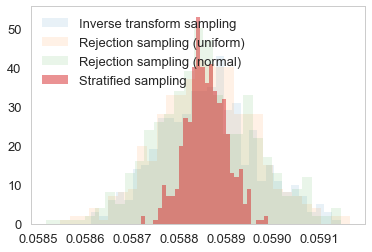

In [23]:
plt.hist(E_inv, 30, alpha=0.1, label='Inverse transform sampling');
plt.hist(E_uni, 30, alpha=0.1, label='Rejection sampling (uniform)');
plt.hist(E_norm, 30, alpha=0.1, label='Rejection sampling (normal)');
plt.hist(E_strat, 30, alpha=0.5, label='Stratified sampling');
plt.legend(loc=2);

In [24]:
print('The estimated variance of each estimate of E[h(X)] (total sample size in each simulation: 10000):')
print('Inverse transform sampling {}'.format(np.var(E_inv)))
print('Rejection sampling with uniform proposal distribution {}'.format(np.var(E_uni)))
print('Rejection sampling with normal proposal distribution {}'.format(np.var(E_norm)))
print('Stratified sampling {}'.format(np.var(E_strat)))
print()
print('Compared with rejection sampling with normal proposal distribution, ')
print('the variance reduction using stratified sampling is roughly {:.1f}.'\
      .format(np.var(E_norm) / np.var(E_strat)))

The estimated variance of each estimate of E[h(X)] (total sample size in each simulation: 10000):
Inverse transform sampling 1.0315666174808508e-08
Rejection sampling with uniform proposal distribution 1.0346500921144041e-08
Rejection sampling with normal proposal distribution 1.1487608922210426e-08
Stratified sampling 1.8864478017771698e-09

Compared with rejection sampling with normal proposal distribution, 
the variance reduction using stratified sampling is roughly 6.1.


As we can see, the variance of the estimate using stratified sampling is roughly an order of magnitude smaller than that of previous estimates (in Part A).

## Problem 3: Linear Regression

Consider the following base Regression class, which roughly follows the API in the python package `scikit-learn`.

Our model is the the multivariate linear model whose MLE solution or equivalent cost minimization was talked about in lecture:

$$y = X\beta + \epsilon$$
where $y$ is a length $n$ vector, $X$ is an $m \times p$ matrix created by stacking the features for each data point, and $\beta$ is a $p$ length vector of coefficients.

The class showcases the API:

$fit(X, y)$: Fits linear model to $X$ and $y$.

$get\_params()$: Returns $\hat{\beta}$ for the fitted model. The parameters should be stored in a dictionary with keys "intercept" and "coef" that give us $\hat{\beta_0}$ and $\hat{\beta_{1:}}$. (The second value here is thus a numpy array of coefficient values)

$predict(X)$: Predict new values with the fitted model given $X$.

$score(X, y)$: Returns $R^2$ value of the fitted model.

$set\_params()$: Manually set the parameters of the linear model.



In [25]:
class Regression(object):
    
    def __init__(self):
        self.params = dict()
    
    def get_params(self, k):
        return self.params[k]
    
    def set_params(self, **kwargs):
        for k,v in kwargs.iteritems():
            self.params[k] = v
        
    def fit(self, X, y):
        raise NotImplementedError()
        
    def predict(self, X):
        raise NotImplementedError()
        
    def score(self, X, y):
        raise NotImplementedError()

### Part A:  a class for Ordinary Least Squares

Inherit from this class to create an ordinary Least Squares Linear Regression class. 

It's signature will look like this:

`class OLS(Regression):`

Implement `fit`, `predict` and `score`. This will involve some linear algebra. (You might want to read up on pseudo-inverses before you directly implement the linear algebra on the lecure slides).

#### $R^2$ score

To implement `score`, look below:

The $R^2$ score is defined as: $${R^{2} = {1-{SS_E \over SS_T}}}$$

Where:

$$SS_T=\sum_i (y_i-\bar{y})^2, SS_R=\sum_i (\hat{y_i}-\bar{y})^2, SS_E=\sum_i (y_i - \hat{y_i})^2$$
where  ${y_i}$ are the original data values, $\hat{y_i}$ are the predicted values, and $\bar{y_i}$ is the mean of the original data values.



### Answer to Problem 3 Part A

In [26]:
import numpy as np

class OLS(Regression):
    def __init__(self):
        super().__init__()
    
    def fit(self, X, y):
        if len(X) != len(y):
            raise ValueError('Inconsistent dimensionality.')
        X = np.concatenate((np.ones((len(X), 1)), X), axis=1)
        beta = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), y)
        self.params['intercept'] = beta[0]
        self.params['coef'] = beta[1:]
        return self
    
    def predict(self, X):
        if not 'coef' in self.params:
            raise ValueError('Estimator not fitted.')
        X = np.concatenate((np.ones((len(X), 1)), X), axis=1)
        beta = np.concatenate(([self.params['intercept']], self.params['coef']))
        return np.dot(X, beta)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return 1 - np.sum(np.square(y - y_pred)) / np.sum(np.square(y - np.mean(y)))

### Part B: test your code

We'll create a synthetic data set using the code below. (Read the documentation for `make_regression` to see what is going on).

In [27]:
from sklearn.datasets import make_regression
import numpy as np
np.random.seed(99)
X, y, coef = make_regression(30,10, 10, bias=1, noise=2, coef=True)
coef

array([ 76.6568183 ,  77.67682678,  63.78807738,  19.3299907 ,
        59.01638708,  53.13633737,  28.77629958,  10.01888939,
         9.25346811,  59.55220395])

Verify that your code recovers these coefficients approximately on doing the fit. Plot the predicted `y` against the actual `y`. Also calculate the score using the same sets `X` and `y`. The usage will look something like:

```python
lr = OLS()
lr.fit(X,y)
lr.get_params['coef']
lr.redict(X,y)
lr.score(X,y)
```

### Answer to Problem 4 Part B

In [28]:
lr = OLS()
lr.fit(X, y)
intercept1 = lr.get_params('intercept')
coef1 = lr.get_params('coef')
print('The intercept of the fitted model is {}.'.format(intercept1))
print('The coefficients of the fitted model is {}.'.format(coef1))
print('The L2 distance of the coefficients of the fitted model and the actual coefficients is {:.4f}.'\
      .format(np.linalg.norm(coef - coef1)))

The intercept of the fitted model is 1.345803570783806.
The coefficients of the fitted model is [ 77.20719705  76.51004831  62.97865316  18.4436452   58.50019885
  53.25126559  28.29088241   9.33333359  10.29584457  59.1606719 ].
The L2 distance of the coefficients of the fitted model and the actual coefficients is 2.3087.


Given the order of magnitude of the coefficients, the fitting recovers the coefficients pretty well.

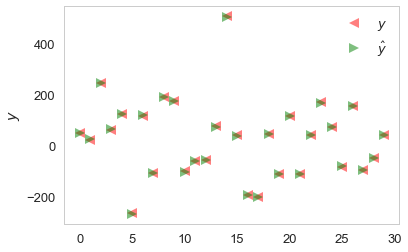

In [29]:
y_pred = lr.predict(X)

plt.plot(range(len(y)), y, 'r<', alpha=0.5, label='$y$');
plt.plot(range(len(y_pred)), y_pred, 'g>', alpha=0.5, label='$\hat{y}$');
plt.legend();
plt.ylabel('$y$');

As we can see, the predicted $y$s are very close to the actual $y$s.

In [30]:
r2 = lr.score(X, y)
print('The R2 score is {}.'.format(r2))

The R2 score is 0.9999155832062194.
